In [1]:
from fit.datamodules.tomo_rec import LoDoPaB_TRecFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D, get_polar_rfft_coords_sinogram
from fit.utils import denormalize, convert2DFT
from fit.modules import TRecTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

import wget
from os.path import exists

In [2]:
seed_everything(22122020)

Global seed set to 22122020


22122020

In [3]:
dm = LoDoPaB_TRecFITDM(batch_size=4, gt_shape=111, num_angles=33)
# FIT: TRec + FBP vs FIT: TRec
with_fbp = True

dm.prepare_data()
dm.setup()

In [4]:
angles = dm.gt_ds.get_ray_trafo().geometry.angles
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [5]:
img_shape = dm.gt_shape

In [6]:
proj_r, proj_phi, src_flatten = get_polar_rfft_coords_sinogram(angles=angles, 
                                                               det_len=det_len)
target_r, target_phi, dst_flatten, order = get_polar_rfft_coords_2D(img_shape=img_shape)

In [7]:
n_heads = 8
d_query = 32
model = TRecTransformerModule(d_model=n_heads * d_query, 
                              sinogram_coords=(proj_r, proj_phi),
                              target_coords=(target_r, target_phi),
                              src_flatten_coords=src_flatten, 
                              dst_flatten_coords=dst_flatten, 
                              dst_order=order,
                              angles=angles, 
                              img_shape=img_shape,
                              detector_len=det_len,
                              loss='prod', 
                              use_fbp=with_fbp, 
                              init_bin_factor=1, 
                              bin_factor_cd=5,
                              lr=0.0001, 
                              weight_decay=0.01, 
                              attention_type='linear', 
                              n_layers=4,
                              n_heads=n_heads, 
                              d_query=d_query, 
                              dropout=0.1, 
                              attention_dropout=0.1)

In [8]:
trainer = Trainer(max_epochs=350, 
                  gpus=1,
                  checkpoint_callback=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_mse',
                                            mode='min',
                                            prefix='best_val_loss_'
                                        ), 
                  deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
# Uncomment the next line if you want to train your own model. 
# trainer.fit(model, datamodule=dm);

In [10]:
if not exists('./models/trec_lodopab/lodopab_trec.ckpt'):
    wget.download('https://cloud.mpi-cbg.de/index.php/s/PBGWkv9qCFFRW5z/download',
                  out='./models/trec_lodopab/lodopab_trec.ckpt')
    
if not exists('./models/trec_lodopab/lodopab_trec_fbp.ckpt'):
    wget.download('https://cloud.mpi-cbg.de/index.php/s/utoq7YHxITd8VJy/download',
                  out='./models/trec_lodopab/lodopab_trec_fbp.ckpt')

In [11]:
if with_fbp:
    path = './models/trec_lodopab/lodopab_trec_fbp.ckpt'
else:
    path = './models/trec_lodopab/lodopab_trec.ckpt'

In [12]:
model = TRecTransformerModule.load_from_checkpoint(path, 
                                               sinogram_coords=(proj_r, proj_phi),
                              target_coords=(target_r, target_phi),
                              src_flatten_coords=src_flatten, 
                              dst_flatten_coords=dst_flatten, 
                              dst_order=order, angles=angles, strict=False)

In [13]:
test_res = trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tbuchhol/Programs/miniconda3/envs/fit_test/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

/home/tbuchhol/.local/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


bin_factor set to 1.
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Mean PSNR': array(30.976335525512695, dtype=float32),
 'SEM PSNR': array(0.03192516043782234, dtype=float32)}
--------------------------------------------------------------------------------


In [14]:
for x_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in dm.test_dataloader():
    break

In [15]:
model.cpu();

In [16]:
pred_img, pred_img_before_conv = model.get_imgs(x_fc, fbp_fc, y_fc, amp_min, amp_max)

/home/tbuchhol/Gitrepos/FourierImageTransformer/fit/modules/TRecTransformerModule.py:357: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:162.)
  pred_fc_[:, :tmp.shape[1]] = tmp


In [17]:
# Before the projection we normalized the image, now we undo this for the visualization.
# After denormalization we set all pixels outside of the projection-area to zero
pred_img = denormalize(pred_img, dm.mean, dm.std) * dm.__get_circle__()
y_real = denormalize(y_real, dm.mean, dm.std) * dm.__get_circle__()

In [18]:
dft_fbp = convert2DFT(x=fbp_fc[:,model.dst_flatten_order], amp_min=amp_min, amp_max=amp_max,
                              dst_flatten_order=model.dst_flatten_order, img_shape=model.hparams.img_shape)
fbp_img = torch.roll(torch.fft.irfftn(model.mask * dft_fbp[0], s=2 * (model.hparams.img_shape,)),
                     2 * (model.hparams.img_shape // 2,), (0, 1))

fbp_img = (fbp_img - fbp_img.min())*y_real.max()/(fbp_img.max() - fbp_img.min())
fbp_img = fbp_img * dm.__get_circle__()

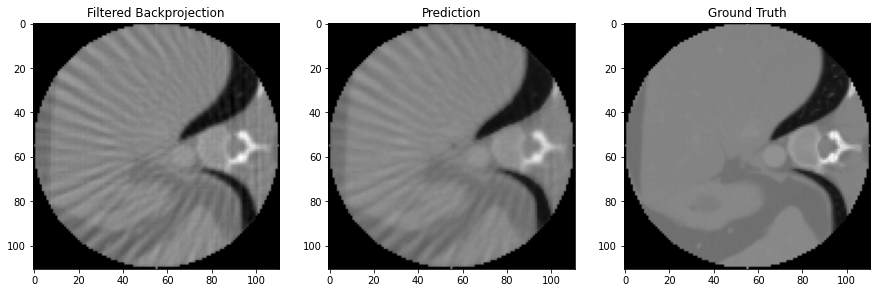

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(fbp_img, cmap='gray', vmin=y_real[0].min(), vmax=y_real[0].max())
plt.title('Filtered Backprojection');
plt.subplot(1,3,2)
plt.imshow(pred_img[0].detach(), cmap='gray', vmin=y_real[0].min(), vmax=y_real[0].max())
plt.title('Prediction');
plt.subplot(1,3,3)
plt.imshow(y_real[0], cmap='gray')
plt.title('Ground Truth');